In [1]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.color
import cv2
from mpl_toolkits.mplot3d import Axes3D
from src.cp_hw5 import *

/home/aramesh/anaconda3/envs/comp-photo/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [77]:
# I have previously done this assignment to a large extent in 16720A (Fall). 
# Re-using a lot of code from my submission in this assignemnt.
# Code re-used has been thrown into this cell.

def loadData(path = "./data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    s: tuple
        Image shape

    """

    I = None
    s = None
    
    image_array = []
    
    for i in range(1,8) : 
        image_name = path + 'input_' + str(i) + '.tif'
        img_bgr = cv2.imread(image_name, -1)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        if i == 1 : print(img_rgb.max(), img_rgb.min(), img_rgb)
        plt.imshow(img_rgb)
        plt.show()
        img_xyz = skimage.color.rgb2xyz(img_rgb)
        img_y = img_xyz[:,:,1].reshape((img_xyz.shape[0]*img_xyz.shape[1]))
        image_array.append(img_y)
        
    I = np.array(image_array)
    
    s = img_xyz.shape

    return I, s

def estimatePseudonormalsCalibrated(I, L):

    """
    Question 1 (e)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals
    """

    B = None
    
    B = np.linalg.pinv(L.T) @ I
    
    return B

def estimatePseudonormalsUncalibrated(I):

    """
    Question 2 (b)

    Estimate pseudonormals without the help of light source directions. 

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P matrix of loaded images

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pesudonormals

    """

    B = None
    L = None
    
    U, S, Vt = np.linalg.svd(I, full_matrices=False)
    
    S[3:] = 0
    
    I = U @ np.diag(S) @ Vt
    Vt_prime = np.diag(np.sqrt(S)) @ Vt
    U_prime = U @ np.diag(np.sqrt(S))
    B = Vt[:3]
    L = U[:3]
    B_prime = Vt_prime[:3]
    L_prime = U_prime[:3]
    return B, L, B_prime, L_prime

def estimateAlbedosNormals(B):

    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    albedos = None
    normals = None
    
    albedos = np.linalg.norm(B, axis=0)
    normals = B / (albedos +1e-10)
    
    return albedos, normals

def displayAlbedosNormals(albedos, normals, s, title=''):

    """
    Question 1 (f)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """

    albedoIm = None
    normalIm = None
    
    albedos = (albedos - np.min(albedos)) / (np.max(albedos) - np.min(albedos))
    normals = np.transpose((normals - np.min(normals)) / (np.max(normals) - np.min(normals)))
    
    albedoIm = albedos.reshape((s[0], s[1])) 
    normalIm = normals.reshape((s[0], s[1], 3))
    
    plt.imshow(albedoIm, cmap='coolwarm')
    plt.title(title)
    plt.show()
    
    plt.imshow(normalIm, cmap='rainbow')
    plt.title(title)
    plt.show()

    return albedoIm, normalIm

def enforceIntegrability(N, s, sig = 3):
        
    """
    Finds a transform Q that makes the normals integrable and transforms them
    by it.
    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals
    s : tuple
        Image shape
    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """
    
    from scipy.ndimage import gaussian_filter

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def estimateShape(normals, s, mode):

    """
    Question 1 (i)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    surface = None
    
    f_x = np.reshape(normals[0, :]/(-normals[2, :] + 1e-10), s[:2])
    f_y = np.reshape(normals[1, :]/(-normals[2, :] + 1e-10), s[:2])
    
    if mode == 0 :
        surface = integrate_poisson(f_x, f_y)
        title = 'poisson intengration'
    elif mode == 1 : 
        surface = integrate_frankot(f_x, f_y)
        title = 'frankot integration'
    else :
        print('mode should be 0 or 1')
        return 0

    surface = (surface - np.min(surface)) / (np.max(surface) - np.min(surface))
    
    plotSurface(surface, title)
    
    return surface


def plotSurface(surface, title=''):

    """
    Question 1 (i) 

    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    Returns
    -------
        None

    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(surface.shape[0]), np.arange(surface.shape[1]))
    ax.plot_surface(X.T, Y.T, surface, cmap='coolwarm')
    plt.show()
    
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from mpl_toolkits.mplot3d import Axes3D
def plot_surface_ls(Z, flip_z=False) :
    # Z is an HxW array of surface depths
    H, W = Z.shape
    x, y = np.meshgrid(np.arange(0,W), np.arange(0,H))
    # set 3D figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # add a light and shade to the axis for visual effect
    # (use the ‘-’ sign since our Z-axis points down)
    ls = LightSource()
    
    if flip_z == True : Z = -Z
    
    color_shade = ls.shade(Z, plt.cm.gray)
    # display a surface
    # (control surface resolution using rstride and cstride)
    surf = ax.plot_surface(x, y, Z, facecolors=color_shade, rstride=4, cstride=4)
    # turn off axis
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


39937 98 [[[504 426 555]
  [565 501 652]
  [524 488 593]
  ...
  [543 500 520]
  [459 453 472]
  [521 511 513]]

 [[417 348 473]
  [522 454 598]
  [587 553 670]
  ...
  [448 435 467]
  [443 456 494]
  [549 551 547]]

 [[412 408 508]
  [489 449 509]
  [494 444 541]
  ...
  [554 543 692]
  [559 569 658]
  [518 517 520]]

 ...

 [[599 520 587]
  [569 446 572]
  [705 560 722]
  ...
  [612 485 576]
  [599 453 604]
  [578 439 623]]

 [[619 498 614]
  [700 553 744]
  [612 491 612]
  ...
  [644 505 622]
  [757 616 759]
  [586 481 663]]

 [[669 524 685]
  [749 620 818]
  [472 372 432]
  ...
  [738 637 775]
  [703 606 758]
  [590 532 651]]]


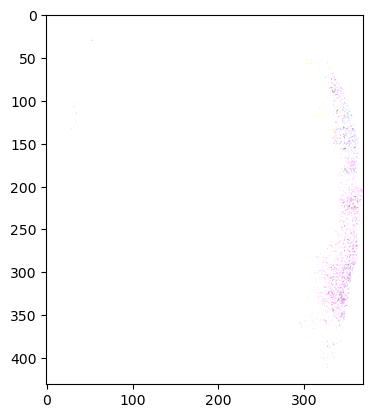

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


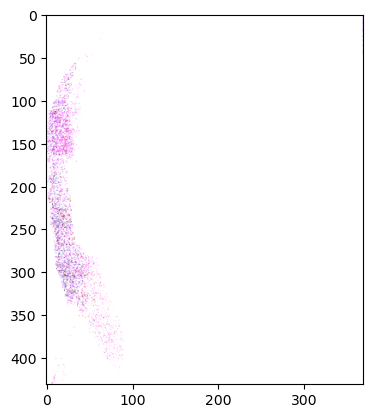

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


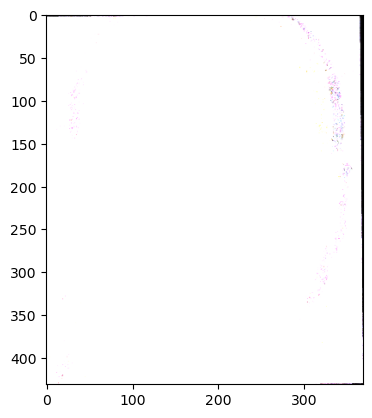

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


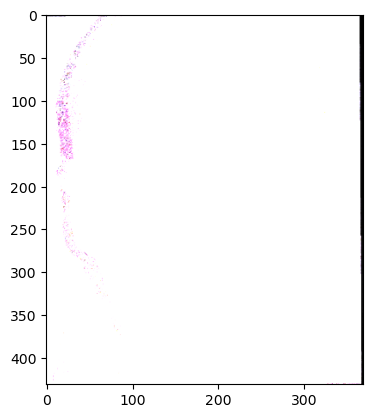

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


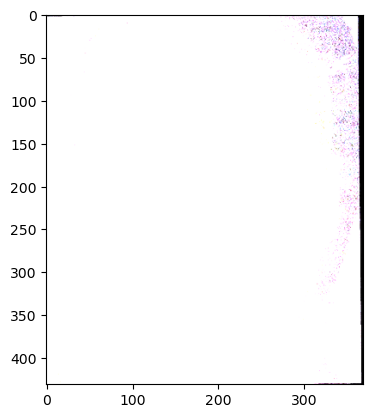

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


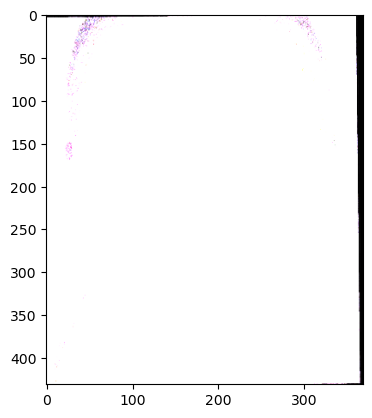

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


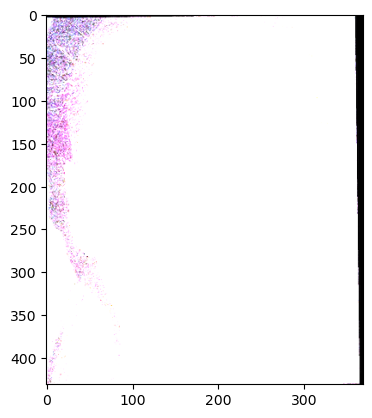

In [23]:
%matplotlib inline
I, s = loadData()
Be,Le, Be_prime, Le_prime = estimatePseudonormalsUncalibrated(I)
Be = Be_prime

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


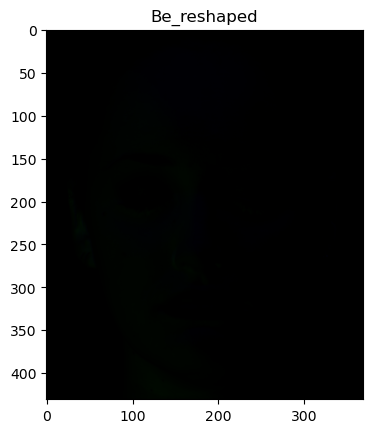

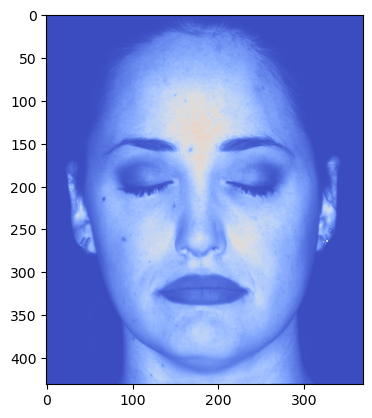

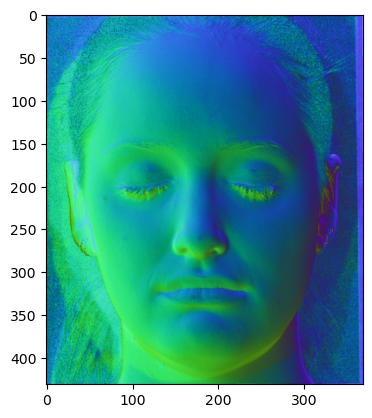

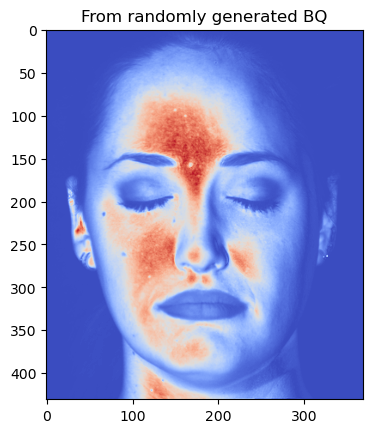

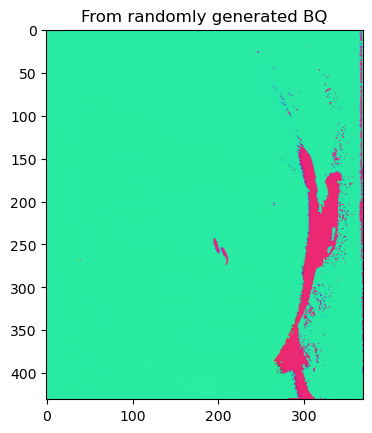

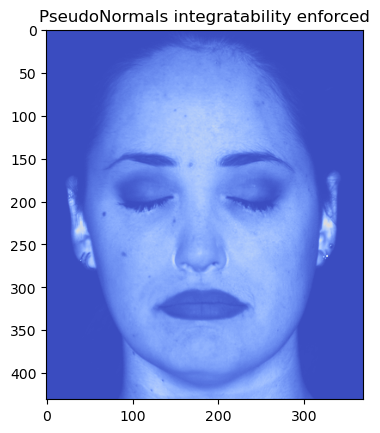

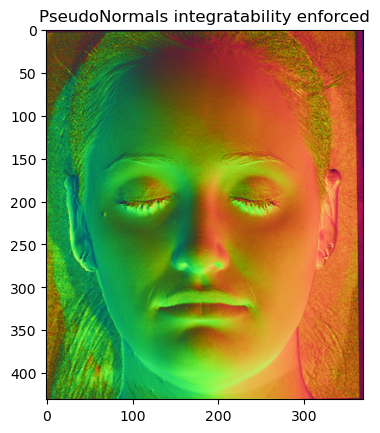

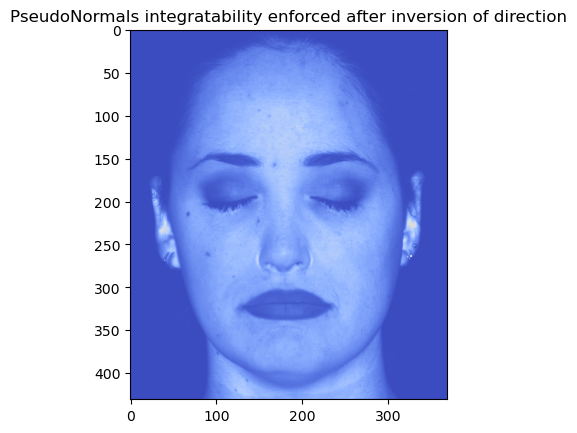

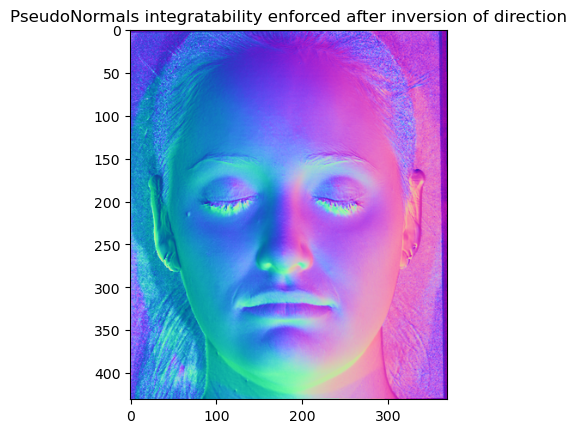

In [24]:
Be_reshaped = Be.T.reshape((s[0], s[1],3))
plt.figure()
plt.imshow(Be_reshaped)
plt.title('Be_reshaped')
plt.show()

albedos, normals = estimateAlbedosNormals(Be)
albedoIm, normalIM = displayAlbedosNormals(albedos, normals,s)

# generate random invertible matrix
randmat = np.random.rand(3,3)
eps = 0.00000001
Q = np.eye(3) * eps + randmat@randmat.T
Q_inv = np.linalg.inv(Q)

LQ = Q @ Le
BQ = Q_inv.T @ Be

albedosQ, normalsQ = estimateAlbedosNormals(BQ)
_, _ = displayAlbedosNormals(albedosQ, normalsQ,s, 'From randomly generated BQ')

# enforcing integratability on Be
Be_enf_int = enforceIntegrability(Be, s[:2])
albedos_enf_int, normals_enf_int = estimateAlbedosNormals(Be_enf_int)
albedoIm_int_enf, normalIM_int_enf = displayAlbedosNormals(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced')

# Applying GBR inversion transform
Gf = np.array([[1,0,0],[0,1,0],[0,0,-1]])
Be_enf_int = Gf @ Be_enf_int 
albedos_enf_int, normals_enf_int = estimateAlbedosNormals(Be_enf_int)
albedoIm_int_enf, normalIM_int_enf = displayAlbedosNormals(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced after inversion of direction')

# normals_enf_int_n = enforceIntegrability(normals, s[:2])
# _ , normalIM_int_enf_n = displayAlbedosNormals(albedos, normals_enf_int_n, s, 'Normals integratability enforced')

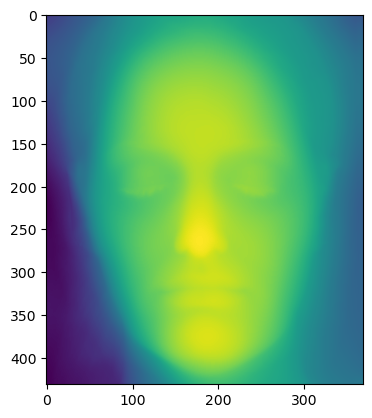

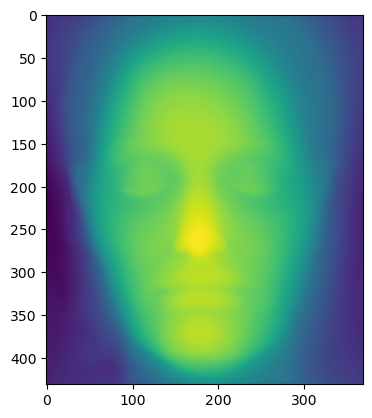

In [30]:
# Normal Integration
# %matplotlib 
# surface_poisson = estimateShape(normals_enf_int, s, 0)
# plt.imshow(surface_poisson)
# plt.show()
# plot_surface_ls(surface_poisson)
# plt.show()

# surface_frankot = estimateShape(normals_enf_int, s, 1)
# plt.imshow(surface_frankot)
# plt.show()
# plot_surface_ls(surface_frankot)
# plt.show()

%matplotlib inline
plt.imshow(surface_poisson)
plt.show()
plt.imshow(surface_frankot)
plt.show()

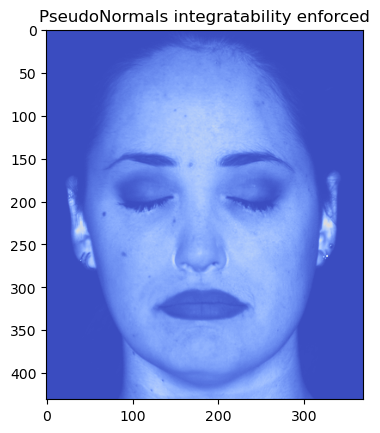

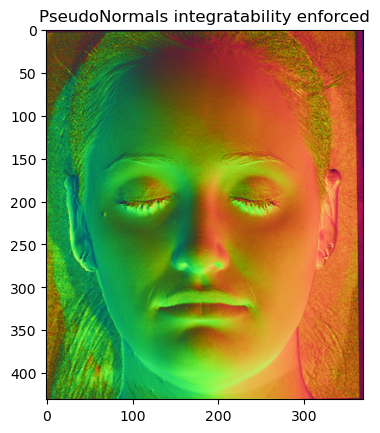

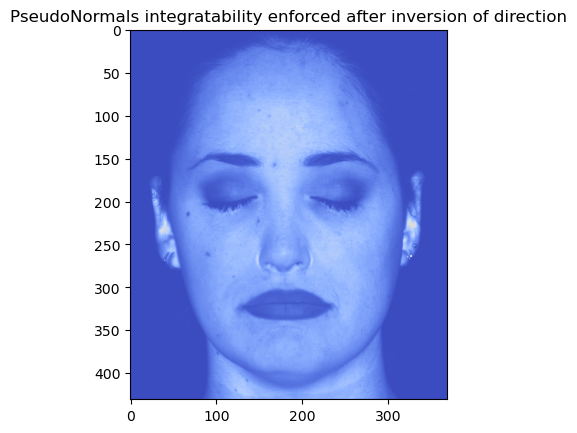

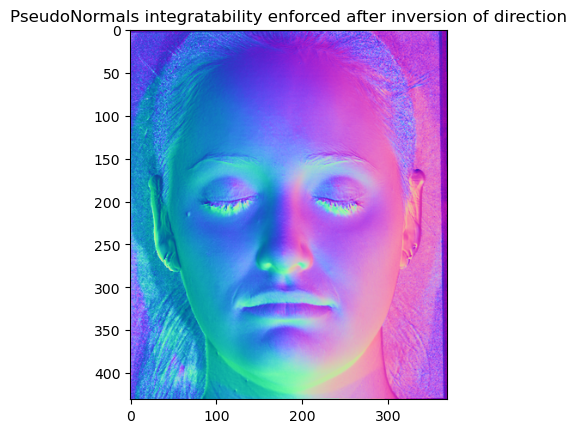

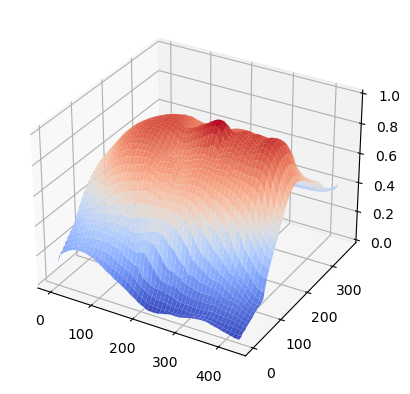

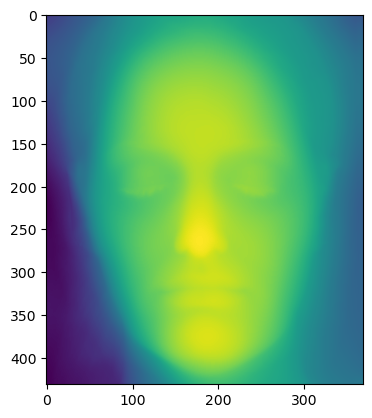

/tmp/ipykernel_103377/3818218282.py:323: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


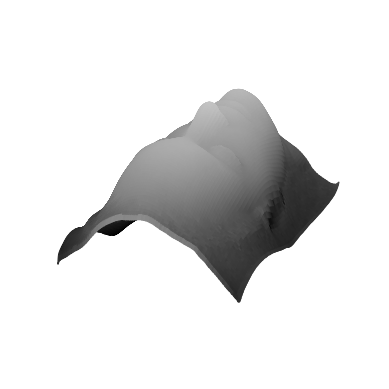

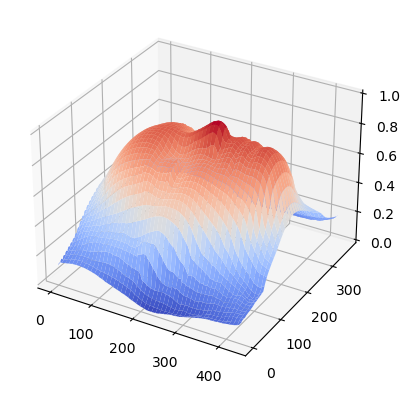

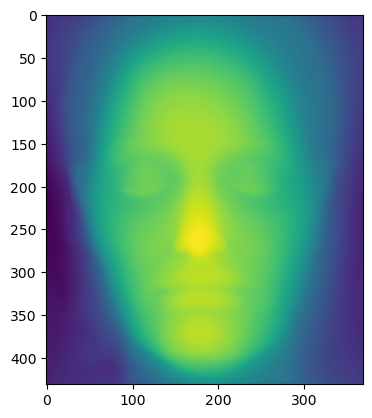

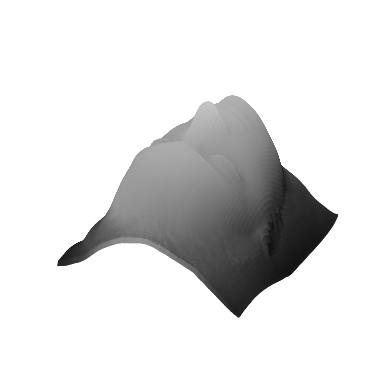

In [73]:
# Lets try this for different G matrices

u = 0
v = 0
l = 1
G = np.array([[1,0,0],[0,1,0],[u,v,l]])
Be_new = np.linalg.inv(G.T) @ Be

# Estimate normals and enforce integratability

# enforcing integratability on Be
Be_enf_int = enforceIntegrability(Be_new, s[:2])
albedos_enf_int, normals_enf_int = estimateAlbedosNormals(Be_enf_int)
albedoIm_int_enf, normalIM_int_enf = displayAlbedosNormals(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced')

# Applying GBR inversion transform if needed (not needed here)
Gf = np.array([[1,0,0],[0,1,0],[0,0,-1]])
Be_enf_int = Gf @ Be_enf_int 
albedos_enf_int, normals_enf_int = estimateAlbedosNormals(Be_enf_int)
albedoIm_int_enf, normalIM_int_enf = displayAlbedosNormals(albedos_enf_int, normals_enf_int, s, 'PseudoNormals integratability enforced after inversion of direction')

# Normal Integration
surface_poisson = estimateShape(normals_enf_int, s, 0)
plt.imshow(surface_poisson)
plt.show()
plot_surface_ls(surface_poisson)
plt.show()

surface_frankot = estimateShape(normals_enf_int, s, 1)
plt.imshow(surface_frankot)
plt.show()
plot_surface_ls(surface_frankot)
plt.show()

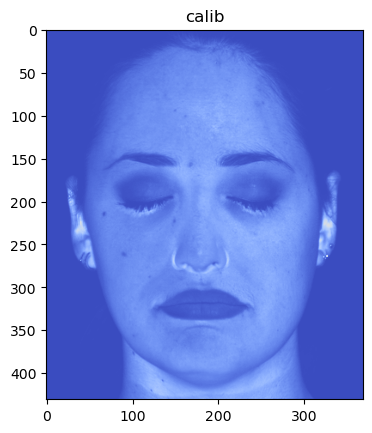

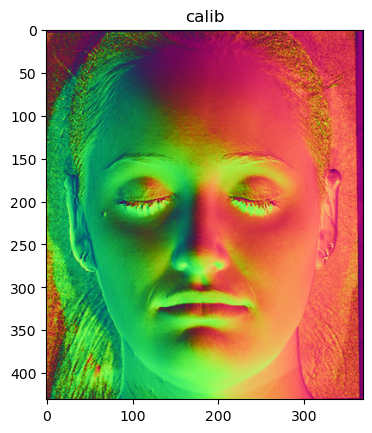

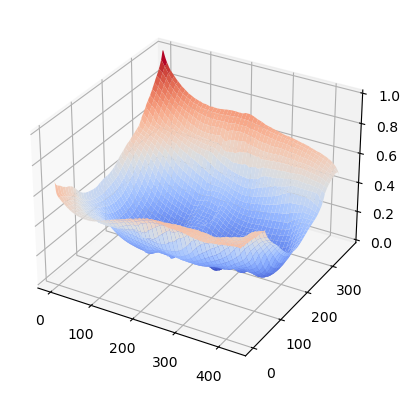

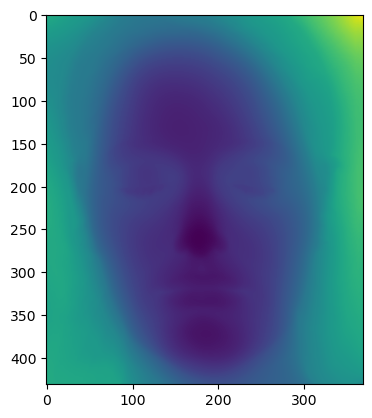

/tmp/ipykernel_103377/2996556867.py:323: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


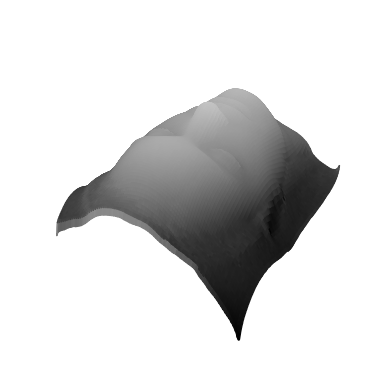

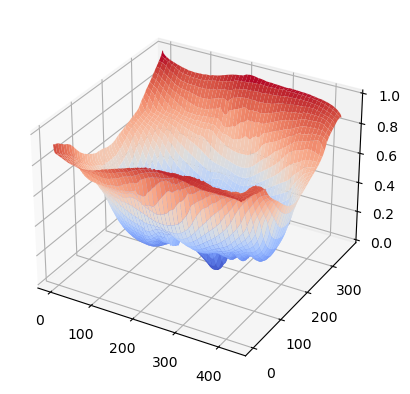

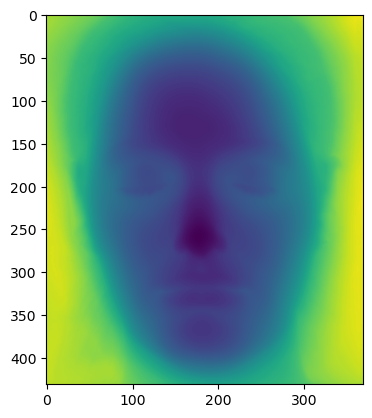

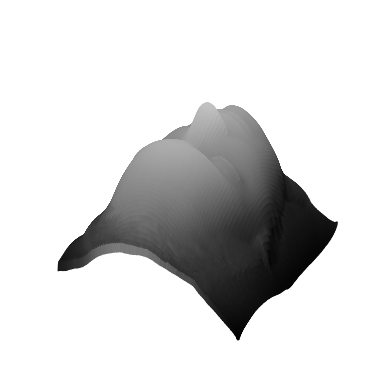

In [82]:
# Calibrated Photometric Stereo

L = load_sources()
Bc = estimatePseudonormalsCalibrated(I, L.T)
albedos_c, normals_c = estimateAlbedosNormals(Bc)
albedoIm_c, normalIM_c = displayAlbedosNormals(albedos_c, normals_c, s, 'calib')

# %matplotlib
surface_poisson = estimateShape(normals_c, s, 0)
plt.imshow(surface_poisson)
plt.show()
plot_surface_ls(surface_poisson, True)
plt.show()

surface_frankot = estimateShape(normals_c, s, 1)
plt.imshow(surface_frankot)
plt.show()
plot_surface_ls(surface_frankot,True)
plt.show()


In [83]:
I.shape

(7, 159039)

In [ ]:
# plt.imshow(np.clip(albedoIm*0.4,0,1),cmap='gray')

In [ ]:
x, y = np.meshgrid(np.arange(0,400), np.arange(0,300))

/bin/bash: matplotlib: command not found
